# **Exchange interaction in three QDs**

All the parameters used here will be similar to the ones in Marek's paper 
(Gimenez, 2007).

# Heisenberg model

The many-electron spectum of the system of 3 quantum dots can be conveniently
mapped onto the Heisenberg Hamiltonian:
$$ H = \frac{1}{4}\left(J_{12} \vec{\sigma_1}\cdot \vec{\sigma_2} +
 J_{23} \vec{\sigma_2}\cdot \vec{\sigma_3} + 
 J_{31} \vec{\sigma_1}\cdot \vec{\sigma_3}  \right) $$

 Since $H$ commutes with $S_z$ and is time reversal symmetric (states with the
 same  $|S_z|$ are degenerate), we can treat only the subspace
 of $S_z=-\frac{1}{2}$.

 In the Jacobi basis: 
 $$\left|\beta_a\right> = \frac{1}{\sqrt{2}}\left(
   \left|\uparrow\downarrow\downarrow\right> - 
   \left|\downarrow\downarrow\uparrow\right> \right)
         \qquad
   \left|\beta_b\right> = \frac{1}{\sqrt{6}}\left(
   \left|\uparrow\downarrow\downarrow\right> + 
   \left|\downarrow\downarrow\uparrow\right> -
   2 \left|\downarrow\uparrow\downarrow\right> \right) 
         \qquad
   \left|\beta_c\right> = \frac{1}{\sqrt{3}}\left(
   \left|\downarrow\downarrow\uparrow\right> + 
   \left|\downarrow\uparrow\downarrow\right> +
   \left|\uparrow\downarrow\downarrow\right> \right) ,
 $$
 the Hamiltonian has the following form: 
 $$
 H = 
 \begin{pmatrix}
  -\frac{3}{4} J_{av} -\frac{3}{4}(J_{31} -  J_{av})    & \frac{\sqrt{3}}{4}(J_{23}-J_{12}) & 0 \\
  \frac{\sqrt{3}}{4}(J_{23}-J_{12})   & -\frac{3}{4} J_{av} + \frac{3}{4}(J_{31} -  J_{av}) & 0 \\
  0   &     0    &      \frac{3}{4} J_{av} 
 \end{pmatrix},
 $$
where $J_{av} = \frac{1}{3}\left(J_{12}+J_{23}+J_{31}\right)  $.

Depending on the relations between $J_{12}, J_{23}, J_{31}$, the Hamiltonian
diagonalizes in a different way. Two particular cases of a linear chain 
and a triangular array of three QDs will be investigated.





# Loading modules and defining main variables

In [1]:
import os, sys
sys.path.append(os.path.dirname(os.getcwd()))

import qudipy as qd
import qudipy.potential as pot
import qudipy.exchange as exch
from scipy.signal import find_peaks    # for finding local minima

from tqdm import tqdm
import time
import math
import numpy as np
import matplotlib.pyplot as plt
import copy

import gc   # for memory cleanup
#required if parallelization is requested
# from numba import njit, boolean, int32, double, prange

Specifying the Rydberg parameters in GaAs (in SI units):

In [2]:
Ry = 5.93e-3 * 1.6e-19  # J
a_B = 9.79e-9    # m

### Create control voltage names and variables the same way you would normally do

In [3]:
ctrl_names = ['V1','V2','V3']
 
V1 = np.arange(9, 12, .2) * Ry
V2 = np.arange(9, 12, .2) * Ry
V3 = np.arange(9, 12, .2) * Ry

ctrl_vals = [V1, V2, V3]


### Specify some constants for the potentials 

In [4]:
csts = qd.Constants('GaAs')

dot_sep = 4 * a_B
dot_width = 2.3 * a_B

omega = csts.hbar / (csts.me * dot_width**2 )
print('omega = {:e} Hz'.format(omega))

omega = 3.407935e+12 Hz


### Specify the x and y points you would like to have in a grid, and initialize the GridParameters object

In [5]:
x_grid = np.arange(-3 * dot_sep, 3 * dot_sep, dot_sep/30)
y_grid = np.arange(-3 * dot_sep, 3 * dot_sep, dot_sep/30)

gparams = qd.potential.GridParameters(x_grid, y_grid)


Define function that creates a combination of Gaussian potentials that will be interpolated over different voltage values

In [6]:
def create_gaus_pots(voltages, gparams, x_pos=[0], y_pos=[0], widths=1e-9):
    # The required additional arguments of the function are: 
    # x_pos, y_pos -- numpy arrays of x and y dot positions, respectively
    # widths -- array of dot widths, or a single value to be used for each dot
 
    #in case any of the inputs is a list/tuple
    x_pos, y_pos, voltages = np.array(x_pos), \
                            np.array(y_pos), \
                                np.array(voltages)
    num_dots = x_pos.shape[0]
    
    # Get coordinates from mesh and repeat them as many times as there are dots
    x = np.repeat(gparams.x_mesh[..., np.newaxis], num_dots, axis=2)
    y = np.repeat(gparams.y_mesh[..., np.newaxis], num_dots, axis=2)

    # if only one width is specified, repeat it for all dots
    if isinstance(widths, (int, float)):
        d = np.repeat(widths, num_dots)         # d is just a shorter name
    else:
        d =  np.array(widths)                   # d is just a shorter name

    return np.sum(- voltages *  
                    np.exp(- ((x - x_pos)**2 + (y - y_pos)**2) / d**2), axis=2)


# Linear chain of dots

## Building potential

Dictionary of the parameters of the dot chain:

In [7]:
chain_params = {'x_pos': [-dot_sep, 0, dot_sep], 
                    'y_pos': [0,0,0], 'widths':dot_width*.7 }

### Get the analytical potential and pass it to build the interpolator:

In [8]:
chain_pot_params = pot.analytical_potential(ctrl_vals, ctrl_names, 
                                        create_gaus_pots, x_grid, y_grid, 
                                            **chain_params)

chain = pot.build_interpolator(chain_pot_params, 
                                          constants=qd.Constants("GaAs"))

### Now specify the potentials to interpolate around, and plot it


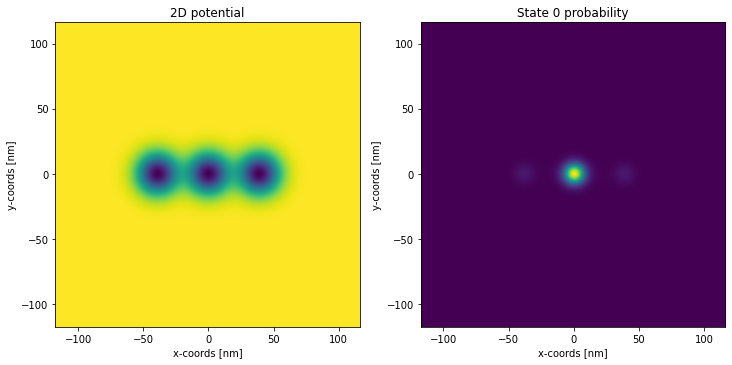

array([[-1.34192245e-55, -3.03514233e-55, -6.77132306e-55, ...,
        -1.49008429e-54, -6.77132306e-55, -3.03514233e-55],
       [-4.58030265e-55, -1.03596676e-54, -2.31121470e-54, ...,
        -5.08601449e-54, -2.31121470e-54, -1.03596676e-54],
       [-1.54206884e-54, -3.48783078e-54, -7.78125913e-54, ...,
        -1.71232888e-53, -7.78125913e-54, -3.48783078e-54],
       ...,
       [-5.12101654e-54, -1.15826470e-53, -2.58405822e-53, ...,
        -5.68642868e-53, -2.58405822e-53, -1.15826470e-53],
       [-1.54206884e-54, -3.48783078e-54, -7.78125913e-54, ...,
        -1.71232888e-53, -7.78125913e-54, -3.48783078e-54],
       [-4.58030265e-55, -1.03596676e-54, -2.31121470e-54, ...,
        -5.08601449e-54, -2.31121470e-54, -1.03596676e-54]])

In [9]:

 
 #starting with the no-bias case
v_vec_sym = np.array([10, 10, 10]) * Ry
# add potential to the gridparams objects

# add potential to the gridparams objects
gparams.update_potential(create_gaus_pots(v_vec_sym, gparams, **chain_params))

# Plot the 2D potential and the ground state wavefunction
chain.plot(v_vec_sym, plot_type='2D',  show_wf=True)
gparams.potential


In [10]:
%%script false 
            # Plot various 1D slices, one with a ground state wavefunction probability
chain.plot(v_vec_sym, plot_type='1D', y_slice=0, show_wf=True)
chain.plot(v_vec_sym, plot_type='1D', y_slice=dot_sep, show_wf=True)


Couldn't find program: 'false'


Clearly, the ground state wavefunction is distributes across all dots.

In [11]:
### Plotting the potential in the case of bias

In [12]:
%%script false 

v_vec_asym = np.array([10.3, 10, 10]) * Ry
# Plot the 2D potential
chain.plot(v_vec_asym, plot_type='2D', show_wf=True)
chain.plot(v_vec_asym, plot_type='1D', y_slice=0, show_wf=True)


Couldn't find program: 'false'


                                                                            This time, the wavefunction is almost fully localized in the leftmost dot. 


### Saving CME libraries

Can be run when necessary to save the libraries of CMEs for faster calculations. They use Rydberg units with `omega=1.0` by default

In [13]:
%%script false
omega = 7.53E+12        #value used from one of the optimization results

durations = {}
for n in range(5,11):
    temp = time.time()
    matrix = exch.calc_origin_cme_matrix(n, n,  # parallelize=True,
                           save_dir='..\\tutorials\\QuDiPy tutorial data\\CMEs')
                           #save_dir=None)
    durations['n='+str(n)]= time.time() - temp
    del matrix
    del temp
    gc.collect()
    
print(durations)


"\nomega = 7.53E+12        #value used from one of the optimization results\n\ndurations = {}\nfor n in range(5,11):\n    temp = time.time()\n    matrix = exch.calc_origin_cme_matrix(n, n,  # parallelize=True,\n                           save_dir='..\\tutorials\\QuDiPy tutorial data\\CMEs')\n                           #save_dir=None)\n    durations['n='+str(n)]= time.time() - temp\n    del matrix\n    del temp\n    gc.collect()\n    \nprint(durations)\n#"

## Solving many-electron Schrodinger equation

Let us start with solving the 3-electron problem.
If we disregard the exchange between the first and the third dot in the chain
($J_{31}=0$), the Heisenberg Hamiltonian diagonalizes with the eigenvalues 
$\epsilon_1< \epsilon_2 < \epsilon_3$ that relate to the exchange values 
in the following way:
$$
\alpha = 2 (\epsilon_2 -\epsilon_1)  - (\epsilon_3 -\epsilon_1), 
\quad
\beta = \frac{1}{3}\sqrt{4(\epsilon_3 -\epsilon_1)^2-\alpha^2};
\qquad J_{12}, J_{23} =\frac{\alpha \pm \beta}{2}
$$

For a symmetric system ($J_{12}=J_{23}=J$) we must obtain
 $$\epsilon_2-\epsilon_1 = J, \quad  \epsilon_3 - \epsilon_2= J/2$$

Defining the function to extract the exchange values: 

In [14]:
#'''
allens = []
#for n in [10,11,12,13,14]:
#for n in [10,12,14,16]:
for n in [5,5,5,5]:
    ens, __ = qd.qutils.solvers.solve_many_elec_SE(gparams, n_elec=3, 
                                                 n_xy_ho=[n,n], 
                                                 n_se=8, 
                                                 n_sols=6,
                                                 consts=csts,
                                                 optimize_omega=True,
                                                 omega=7.53E+12,
                                                 opt_omega_n_se=8,
                                                 ho_cmes=None,
                                                #cme_dir=None, 
                                                  cme_dir='..\\tutorials\\QuDiPy tutorial data\\CMEs',
                                                 spin_subspace=[1]);
    print("\nn_se: ",n, "ens: ", ens)
    allens.append(ens)
#'''

Begining many body energy calculation...

Optimizing choice of omega in approximating the single electron orbitals...

Optimization terminated successfully.
Found an optimal omega of 5.52E+12.

Done!
Elapsed time is 3.1070022583007812 seconds.

Finding 2D harmonic orbitals at origin...

Done!

Finding A matrix...

Done!
Elapsed time is 0.26791834831237793 seconds.

Loading harmonic orbital CME matrix from the specified directory

Transforming the CME library to single electron basis...

Done!
Elapsed time is 0.004999637603759766 seconds.

Building 2nd quantization Hamiltonian and diagonalizing...


KeyboardInterrupt: 

In [ ]:
def ex_3_dots(gparams, nx=8, ny=8, n_se=3 ):
    n_elec = 3
    ens, __ = qd.qutils.solvers.solve_many_elec_SE(gparams, n_elec, 
                                                 n_xy_ho=[nx,ny], 
                                                 n_se=n_se, 
                                                 n_sols=3,
                                                 consts=csts,
                                                 optimize_omega=True,
                                                 omega=7.53E+12,
                                                 opt_omega_n_se=4,
                                                 ho_cmes=None,
                                                 cme_dir='.\\QuDiPy tutorial data\\CMEs',
                                                 spin_subspace=[1])
    e1, e2, e3 = ens
    alpha = 2 * (e2 - e1) + (e3 - e2)
    beta = 1/3 *  np.sqrt(4 * (e2 - e1) ** 2 - alpha ** 2)
    return (np.array(ens), np.array((1 / 2 * (alpha + beta), 1 / 2 * abs(alpha - beta) )))


arrs = [ex_3_dots(gparams, nx=n, ny=n, n_se=10) 
                                    for n in range(10,15,2)]
earr = np.array(arrs[:,0])
jarr = np.array(arrs[:,1])

In [ ]:
print('arrs:'+ arrs)

print('\njarr:' + jarr)

# Triangular chain of dots

## Building potential

In [ ]:
triangle_params = {'x_pos': [-dot_sep / 2, dot_sep, -dot_sep / 2],
                    'y_pos': [-dot_sep * np.sqrt(3) / 2, 0, dot_sep * np.sqrt(3) / 2],
                     'widths':dot_width }

### Get the analytical potential and pass it to build the interpolator:

In [ ]:
triangle_pot_params = pot.analytical_potential(ctrl_vals, ctrl_names, 
                                        create_gaus_pots, x_grid, y_grid, 
                                            **triangle_params)

triangle = pot.build_interpolator(triangle_pot_params, 
                                          constants=qd.Constants("GaAs"))



### Now specify the potentials to interpolate around, and plot it


In [ ]:
 #starting with the no-bias case
v_vec_sym = np.array([10, 10, 10]) * Ry
# add potential to the gridparams objects
gparams.update_potential(create_gaus_pots(v_vec_sym, gparams, **triangle_params))

# Plot the 2D potential and the ground state wavefunction
triangle.plot(v_vec_sym, plot_type='2D',  show_wf=True)


In [ ]:

# Plot various 1D slices, one with a ground state wavefunction probability
triangle.plot(v_vec_sym, plot_type='1D', y_slice=0, show_wf=True)
triangle.plot(v_vec_sym, plot_type='1D', y_slice=dot_sep*np.sqrt(3)/2, show_wf=True)



# Splitting the potential into individual dots and pairs of dots

It will be useful to compare the exchange values obtained from the 3-dot 
potential to the values for each pair of dots. To do that, we define functions
that split the potential into the individual dots and then group them by pairs. 


In [ ]:
# Define searcher for local maxima and minima indices of the potential
def peak_ids(interp, voltages):
    # finding where to cut a slice
    y_zero_idx = np.where(np.abs(interp.y_coords) < 1e-15)[0][0]
    pot_slice = interp(voltages)[y_zero_idx,:]
    min_ids = find_peaks(-pot_slice)[0]
    max_ids = find_peaks(pot_slice)[0]
    return min_ids, max_ids

min_ids, max_ids = peak_ids(chain, v_vec_sym)
print('Local maxima of v_vec_sym: ',chain.x_coords[max_ids])


In [ ]:
# Define function that creates separated dots
def sep_dot(interp, voltages, range):
    #range is the 
    # the potential and its maximal value 
    pot  = interp(voltages)
    pot_max = np.max(pot)
    # creating new potential landscape for a dot
    sep_dot_pot = np.full(np.shape(pot), pot_max)
    sep_dot_pot[:, range] = pot[:, range]

    return sep_dot_pot 


min_ids , max_ids = peak_ids(chain, v_vec_sym)
sep_dot_ids = np.split(np.arange(np.shape(chain.x_coords)[0]), max_ids)

sep_dots = [sep_dot(chain, v_vec_sym, rang) for rang in sep_dot_ids]



Plotting the separated dots

In [ ]:
def plot_pots(pots, gparams):
    fig, ax = plt.subplots(1, len(pots), figsize=(10,8))
    for idx,pot in enumerate(pots):

        ax[idx].imshow(pot, interpolation='bilinear', cmap='viridis',
                    origin='lower', extent=[gparams.x.min()/1E-9, 
                    gparams.x.max()/1E-9, gparams.y.min()/1E-9,
                    gparams.y.max()/1E-9]
                    )
        ax[idx].set(xlabel='x-coords [nm]',ylabel='y-coords [nm]',
                            title='2D potential');
                       
plot_pots(sep_dots, gparams)

In [ ]:
#Defining a function of pairs of dots and plotting them
def dot_pairs(sep_dots):
    pair_pots = [np.minimum(sep_dots[i], sep_dots[i+1])
        for i in range(len(sep_dots)-1)]
    return pair_pots

plot_pots(dot_pairs(sep_dots), gparams)